<font color=#000000 size=5 face="微软雅黑">生成对抗网络(GAN)

<font color=#000000 size=3 face="微软雅黑">利用GAN，从噪声分布中生成MNIST图像。根据Goodfellow原版论文，将生成器和鉴别器分别设置为3层全连接网络，实现GAN。

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# 导入MNIST数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data_set/", one_hot=True)

Extracting ./MNIST_data_set/train-images-idx3-ubyte.gz
Extracting ./MNIST_data_set/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data_set/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data_set/t10k-labels-idx1-ubyte.gz


In [27]:
# 训练相关参数
num_steps = 50000
batch_size = 128
learning_rate = 0.0002

In [28]:
# 网络参数
image_input = 784   #28*28 pixels
g_hidden_units = 256  #生成器隐藏层单元个数
d_hidden_units = 256  #鉴别器隐藏层单元个数
noise_input = 100    #噪声输入个数

In [29]:
# 自定义初始化
def glorot_init(shape):
    return tf.random_normal(shape=shape,stddev=1. / tf.sqrt(shape[0] / 2.))

In [30]:
def variable_initializer(image_input, g_hidden_units, d_hidden_units, noise_input):
    # 定义生成器变量
    g_w1 = tf.Variable(glorot_init([noise_input, g_hidden_units]))
    g_b1 = tf.Variable(tf.zeros([g_hidden_units]))
    g_w2 = tf.Variable(glorot_init([g_hidden_units, image_input]))
    g_b2 = tf.Variable(tf.zeros([image_input]))
    # 定义鉴别器变量
    d_w1 = tf.Variable(glorot_init([image_input, d_hidden_units]))
    d_b1 = tf.Variable(tf.zeros([d_hidden_units]))
    d_w2 = tf.Variable(glorot_init([d_hidden_units, 1]))
    d_b2 = tf.Variable(tf.zeros([1]))
    
    weights = {"g_w1": g_w1, "g_w2": g_w2,
               "d_w1": d_w1, "d_w2": d_w2}
    bias = {"g_b1": g_b1, "g_b2": g_b2,
            "d_b1": d_b1, "d_b2": d_b2}
    return weights, bias

In [31]:
#定义生成器
def generator(g_input, weights, bias):
    hidden_layer = tf.matmul(g_input, weights["g_w1"]) + bias["g_b1"]
    hidden_layer = tf.nn.relu(hidden_layer)
    output_layer = tf.matmul(hidden_layer, weights["g_w2"]) + bias["g_b2"]
    output_layer = tf.nn.sigmoid(output_layer)
    return output_layer

In [32]:
#定义鉴别器
def discriminator(d_input, weights, bias):
    hidden_layer = tf.matmul(d_input, weights["d_w1"]) + bias["d_b1"]
    hidden_layer = tf.nn.relu(hidden_layer)
    output_layer = tf.matmul(hidden_layer, weights["d_w2"]) + bias["d_b2"]
    output_layer = tf.nn.sigmoid(output_layer)
    return output_layer

In [33]:
#构建整个GAN网络
def network(weights, bias):
    #网络的输入
    g_input = tf.placeholder(tf.float32, shape=[None, noise_input], name="input_noise")  #G的输入，来源于随机噪声分布
    d_input = tf.placeholder(tf.float32, shape=[None, image_input], name="discrimination_input") #D的输入，来源于真实图像
    
    #构建生成器网络
    g_output = generator(g_input, weights, bias)  #G的输出，通过噪声分布生成的对抗样本，即假的图像
    
    #构建两个鉴别器
    d_real = discriminator(d_input, weights, bias)  #D的输出，由真实图像作为输入
    d_fake = discriminator(g_output, weights, bias) #D的输出，有假的图像作为输入
    return  g_input, g_output, d_input, d_real, d_fake

In [34]:
#构建损失函数
def loss(d_real, d_fake):
    #生成器损失函数，原论文中为最大化 tf.reduce_mean(tf.log(1 - d_fake))，等效为最小化 -tf.reduce_mean(tf.log(d_fake)) 
    g_loss = -tf.reduce_mean(tf.log(d_fake))    
    d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1 - d_fake))
    return g_loss, d_loss

In [35]:
def gan_model():
    weights, bias = variable_initializer(image_input, g_hidden_units, d_hidden_units, noise_input)
    g_input, g_output,  d_input, d_real, d_fake = network(weights, bias)
    g_loss, d_loss = loss(d_real, d_fake)
    #定义优化器
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #生成器变量
    g_vars = [weights["g_w1"], weights["g_w2"],
              bias["g_b1"], bias["g_b2"]]
    
    #鉴别器变量
    d_vars = [weights["d_w1"], weights["d_w2"],
              bias["d_b1"], bias["d_b2"]]
    
    #创建训练操作
    g_train = g_optimizer.minimize(g_loss, var_list=g_vars)
    d_train = d_optimizer.minimize(d_loss, var_list=d_vars)
    #初始化所有变量
    init = tf.global_variables_initializer()
    #开始训练
    with tf.Session() as sess:
        sess.run(init)
        
        for i in range(num_steps):
            #准备数据
            #获取MNIST数据的下一个batch，只有图像数据需要，标签数据不需要
            batch_x, _ = mnist.train.next_batch(batch_size)
            #产生噪声，作为生成器的输入,下面列举了两种产生随机噪声的方式
            #z = np.random.uniform(-1, 1, size=[batch_size, noise_input])  # 从[-1, 1)的均匀分布中，随机采样
            z = np.random.normal(0, 1, size=(batch_size, noise_input)).astype(np.float32) # # 从均值为1，标准差为1的正态分布中随机采样
            feed_dict = {g_input: z, d_input: batch_x}
            gl, dl = sess.run([g_loss, d_loss], feed_dict=feed_dict)
            if i % 2000 ==0:
                print("Step %i: Generator Loss: %f, Discriminator Loss: %f" % (i, gl, dl))
            
            #训练
            sess.run([g_train, d_train],
                      feed_dict = feed_dict)
        print("Training finished")
        
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for i in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_input])
            # Generate image from noise.
            g = sess.run(g_output, feed_dict={g_input: z})
            # Reverse colours for better display
            g = -1 * (g - 1)
            for j in range(n):
                # Draw the generated digits
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()

Step 0: Generator Loss: 0.188403, Discriminator Loss: 2.145807
Step 2000: Generator Loss: 4.890642, Discriminator Loss: 0.040656
Step 4000: Generator Loss: 4.056353, Discriminator Loss: 0.077246
Step 6000: Generator Loss: 4.722255, Discriminator Loss: 0.113826
Step 8000: Generator Loss: 3.929044, Discriminator Loss: 0.124831
Step 10000: Generator Loss: 3.403121, Discriminator Loss: 0.239187
Step 12000: Generator Loss: 3.300960, Discriminator Loss: 0.243557
Step 14000: Generator Loss: 2.810192, Discriminator Loss: 0.452619
Step 16000: Generator Loss: 3.352144, Discriminator Loss: 0.332495
Step 18000: Generator Loss: 2.687052, Discriminator Loss: 0.420942
Step 20000: Generator Loss: 2.808762, Discriminator Loss: 0.379781
Step 22000: Generator Loss: 2.880643, Discriminator Loss: 0.376953
Step 24000: Generator Loss: 2.626316, Discriminator Loss: 0.447855
Step 26000: Generator Loss: 2.702986, Discriminator Loss: 0.529465
Step 28000: Generator Loss: 2.721970, Discriminator Loss: 0.454984
Ste

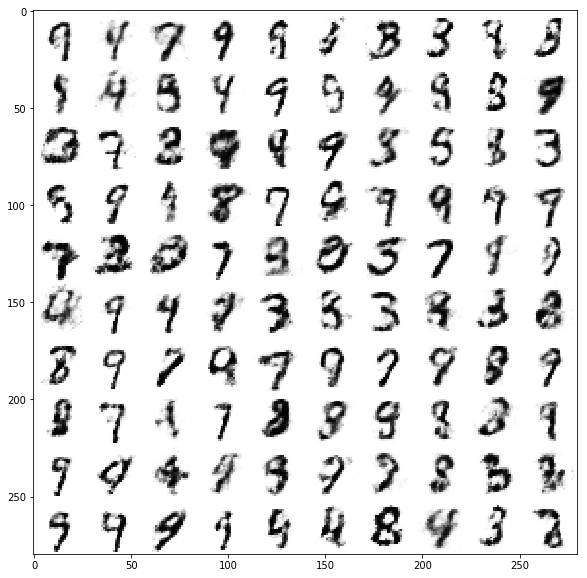

In [36]:
gan_model()